In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, default_data_collator
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import gc
import functools

/home/tianle/anaconda3/envs/diff_compress/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_model_name = "meta-llama/Llama-2-7b-hf"

multilingual_model_dict = {
    "zh": "hfl/chinese-llama-2-7b",
    "ja": "elyza/ELYZA-japanese-Llama-2-7b",
    "ko": "beomi/llama-2-ko-7b"
}

In [4]:
def load_mc4(language, size=10240):
    dataset = load_dataset("mc4", language, streaming=True)
    return dataset["train"].take(size)

def load_oscar(language, size=10240):
    dataset = load_dataset("oscar-corpus/OSCAR-2201", use_auth_token=True, language=language, streaming=True)
    return dataset["train"].take(size)

def load_c4(size=10240):
    dataset = load_dataset("c4", "en", streaming=True)
    return dataset["train"].take(size)

In [5]:
language = "ja"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


In [7]:
finetuned_model = AutoModelForCausalLM.from_pretrained(
    multilingual_model_dict[language],
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.18s/it]


In [8]:
if tokenizer.pad_token_id is None:
    if tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    else:
        tokenizer.pad_token_id = 0

In [9]:
# build dataloader
max_length = 128
batch_size = 32
num_samples = 4096
# preprocess
def preprocess(examples, max_length=128):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_length)

dataset = load_mc4(language, num_samples)
dataset = dataset.map(preprocess, batched=True, batch_size=128, remove_columns=["text", "timestamp", "url"])

# build dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, collate_fn=default_data_collator)

In [10]:
calibration_batch_size = 4
calibration_max_length = 128
lr = 1e-4
num_steps = 100

calibration_dataset = load_c4(calibration_batch_size*num_steps)
calibration_dataset = calibration_dataset.map(functools.partial(preprocess, max_length=calibration_max_length), batched=True, batch_size=128, remove_columns=["text", "timestamp", "url"])

calibration_dataloader = torch.utils.data.DataLoader(calibration_dataset, batch_size=calibration_batch_size, num_workers=4, collate_fn=default_data_collator)

In [11]:
def get_loss(model):
    loss = 0
    tot = 0
    bar = tqdm(dataloader)
    for batch in bar:
        with torch.inference_mode():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            batch["labels"] = batch["input_ids"].clone()
            batch["labels"][batch["labels"] == tokenizer.pad_token_id] = -100
            output = model(**batch)
            loss += output.loss.item()
            tot += 1
            bar.set_description(f"loss: {loss / tot}")
    return loss / tot

In [12]:
get_loss(base_model)

loss: 2.039281355217099: : 128it [00:45,  2.82it/s] 


2.039281355217099

In [13]:
get_loss(finetuned_model)

loss: 1.8086957968771458: : 128it [00:44,  2.90it/s]


1.8086957968771458

In [12]:
finetuned_compressed_model = AutoModelForCausalLM.from_pretrained(
    multilingual_model_dict[language],
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto",
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.18s/it]


In [16]:
class BinaryDiff(nn.Module):
    def __init__(self, base, finetune):
        super().__init__()
        diff = finetune - base

        # U, S, V = torch.svd_lowrank(diff.T.float(), q=1, niter=20)
        quantile = diff.float().abs().mean()
        
        mask = torch.ones_like(diff)
        mask[diff < 0] = -1
        
        self.register_buffer("mask", mask.T)
        self.register_buffer("base", base.T)
        # self.register_parameter(
        #     "coeff",
        #     nn.Parameter(torch.tensor(quantile, dtype=base.dtype, device=base.device)),
        # )
        self.register_parameter("A", nn.Parameter(torch.ones(base.shape[1], 1, dtype=base.dtype, device=base.device)*quantile**0.5))
            #(U @ torch.diag_embed(S.sqrt())).to(base.dtype)))
        self.register_parameter("B", nn.Parameter(torch.ones(1, base.shape[0], dtype=base.dtype, device=base.device)*quantile**0.5))
            #(torch.diag_embed(S.sqrt()) @ V.T).to(base.dtype)))
        del base

    def forward(self, x):
        x = x @ (self.base + (self.A @ self.B) * self.mask)
        return x

In [17]:
for name, module in finetuned_compressed_model.named_modules():
    if "mlp" in name or "self_attn" in name:
        for subname, submodule in module.named_children():
            if (
                "proj" in subname
            ):  # isinstance(submodule, nn.Linear) or isinstance(submodule, compressedDiff):
                print(name + "." + subname)
                base_weight = base_model.get_submodule(name + "." + subname).weight
                finetuned_weight = finetuned_model.get_submodule(
                    name + "." + subname
                ).weight
                compressed = BinaryDiff(
                    base=base_weight,
                    finetune=finetuned_weight,
                )
                del submodule, base_weight
                setattr(module, subname, None)
                gc.collect()
                torch.cuda.empty_cache()
                setattr(module, subname, compressed)

model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.o_proj
model.layers.2.mlp.gate_proj
model.layers.2.mlp.up_proj
model.layers.2.mlp.down_proj
model.layers.3.self_attn.q_proj
model.layers.3.self_attn.k_proj
model.layers.3.self_attn.v_proj
model.layers.3.self_attn.o_proj
model.layers.3.mlp.gate_proj
model.layers.3.mlp.up_proj
model.layers.3.mlp.down_proj
model.layers.4.self_attn.q_proj
model.layers.4.self_attn.k_proj
model.layers.4.self_attn.v_proj
model.layers.4.self_attn.o_proj
model.layers.4.mlp.g

In [17]:
# only scalar
get_loss(finetuned_compressed_model)

loss: 2.0306512927636504: : 128it [00:49,  2.57it/s]


2.0306512927636504

In [18]:
# rank-1 lora
get_loss(finetuned_compressed_model)

loss: 1.9371310072019696: : 128it [01:04,  1.98it/s]


1.9371310072019696

In [19]:
# For fitting a single A100
del base_model
gc.collect()
torch.cuda.empty_cache()

In [26]:
for name, param in finetuned_compressed_model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.abs().mean().item(), param.abs().mean().item())

model.embed_tokens.weight 1.633167266845703e-05 0.01300048828125
model.layers.0.self_attn.q_proj.A 0.00013256072998046875 0.0225830078125
model.layers.0.self_attn.q_proj.B 0.000125885009765625 0.0224609375
model.layers.0.self_attn.k_proj.A 0.00014495849609375 0.0235595703125
model.layers.0.self_attn.k_proj.B 0.00021839141845703125 0.0234375
model.layers.0.self_attn.v_proj.A 0.00139617919921875 0.0279541015625
model.layers.0.self_attn.v_proj.B 0.005462646484375 0.0279541015625
model.layers.0.self_attn.o_proj.A 0.00177001953125 0.0289306640625
model.layers.0.self_attn.o_proj.B 0.004730224609375 0.0289306640625
model.layers.0.mlp.gate_proj.A 0.0004253387451171875 0.0306396484375
model.layers.0.mlp.gate_proj.B 0.0004787445068359375 0.0308837890625
model.layers.0.mlp.up_proj.A 0.00054168701171875 0.03076171875
model.layers.0.mlp.up_proj.B 0.00054168701171875 0.0308837890625
model.layers.0.mlp.down_proj.A 0.0004634857177734375 0.031494140625
model.layers.0.mlp.down_proj.B 0.0016937255859375 

In [20]:
optimizer = torch.optim.AdamW(finetuned_compressed_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_steps)

bar = tqdm(calibration_dataloader)

train_loss_list = []
test_loss_list = []

for step, batch in enumerate(bar):
    batch = {k: v.to(finetuned_compressed_model.device) for k, v in batch.items()}
    with torch.inference_mode():
        finetuned_outputs = finetuned_model(**batch)
    finetuned_compressed_outputs = finetuned_compressed_model(**batch)

    logits_diff = (finetuned_outputs.logits - finetuned_compressed_outputs.logits)
    loss = torch.mean(logits_diff ** 2)
    train_loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (step + 1) % 20 == 0:
        test_loss = get_loss(finetuned_compressed_model)
        bar.set_description(f"train loss: {loss.item()}, test loss: {test_loss}")
        test_loss_list.append(test_loss)

    bar.set_description(f"train loss: {loss.item()}")

loss: 1.9323930284008384: : 128it [01:05,  1.95it/s]it/s]
loss: 1.9059583134949207: : 128it [01:06,  1.94it/s]it/s]                               
loss: 1.9037727182731032: : 128it [01:06,  1.93it/s]it/s]                               
loss: 1.9030745532363653: : 128it [01:06,  1.93it/s]it/s]                               
loss: 1.9033282035961747: : 128it [01:06,  1.93it/s]it/s]                               
train loss: 0.6379461884498596: : 100it [06:15,  3.76s/it]                              


In [21]:
import matplotlib.pyplot as plt

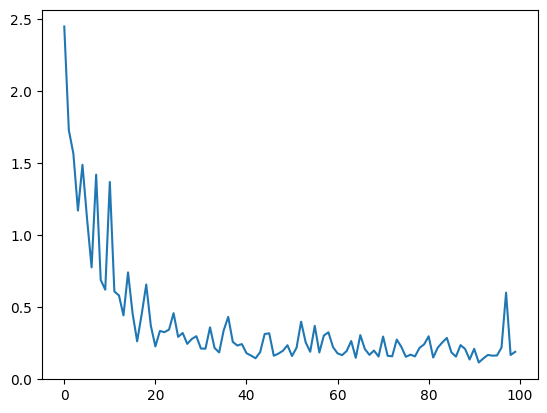

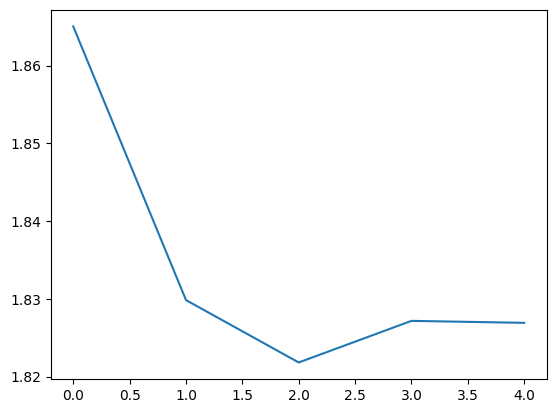

In [21]:
plt.plot(train_loss_list, label="train")
plt.show()
plt.plot(test_loss_list, label="test")
plt.show()

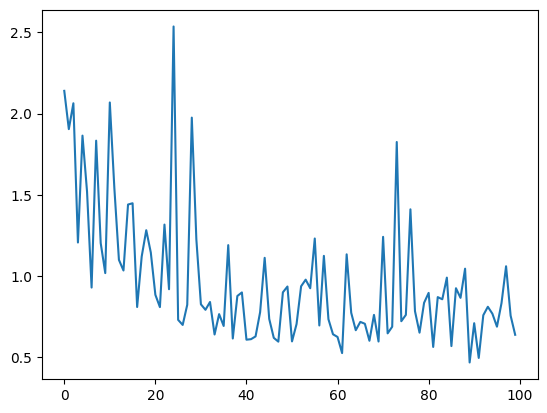

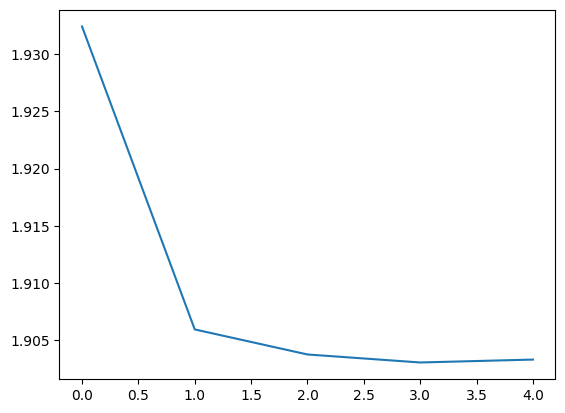

In [22]:
plt.plot(train_loss_list, label="train")
plt.show()
plt.plot(test_loss_list, label="test")
plt.show()